<a href="https://colab.research.google.com/github/Xue-Shangqi/intrusionDetection/blob/main/IntrusionDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Load NSL-KDD Dataset

In [ ]:
url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.csv"
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
           'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
           'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
           'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
           'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
           'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
           'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
           'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
           'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
           'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'unneeded']

df = pd.read_csv(url, names=columns)
df = df.drop(columns=['label', 'unneeded'])

# Preprocess Dataset

In [ ]:
encoder = LabelEncoder()
for col in ['protocol_type', 'service', 'flag']:
  df[col] = encoder.fit_transform(df[col])

scaler = MinMaxScaler()
X = scaler.fit_transform(df)

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Build Autoencoder Model

In [ ]:
class Autoencoder(Model):
  def __init__(self, start_dim):
    super(Autoencoder, self).__init__()
    self.start_dim = start_dim
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(start_dim,)),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(32, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(start_dim, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

start_dim = X.shape[1]
autoencoder  = Autoencoder(start_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

# Train Model

In [ ]:
history = autoencoder.fit(X_train, X_train,
                epochs=25,
                batch_size=64,
                shuffle=True,
                validation_data=(X_test, X_test))


Epoch 1/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0324 - val_loss: 0.0028
Epoch 2/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 3/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 4/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 6/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0010 - val_loss: 8.9097e-04
Epoch 7/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 8.1044e-04 - val_loss: 7.2174e-04
Epoch 8/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.4353e-04 - val_loss: 4.9370e-04
Epoch 9/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 4.2242e-04 - val_loss: 4.1268e-04
Epoch 10/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 3.8101e-04 - val_loss: 3.8396e-04
Epoch 11/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3.4826e-04 - val_l

# Test Model

In [ ]:
X_test_prediction = autoencoder.predict(X_test)
reconstruct_error = np.mean(np.abs(X_test - X_test_prediction), axis=1)
threshold = np.percentile(reconstruct_error, 90)

anomalies = reconstruct_error > threshold

788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


# Display Results

Text(0, 0.5, 'Number of Samples')

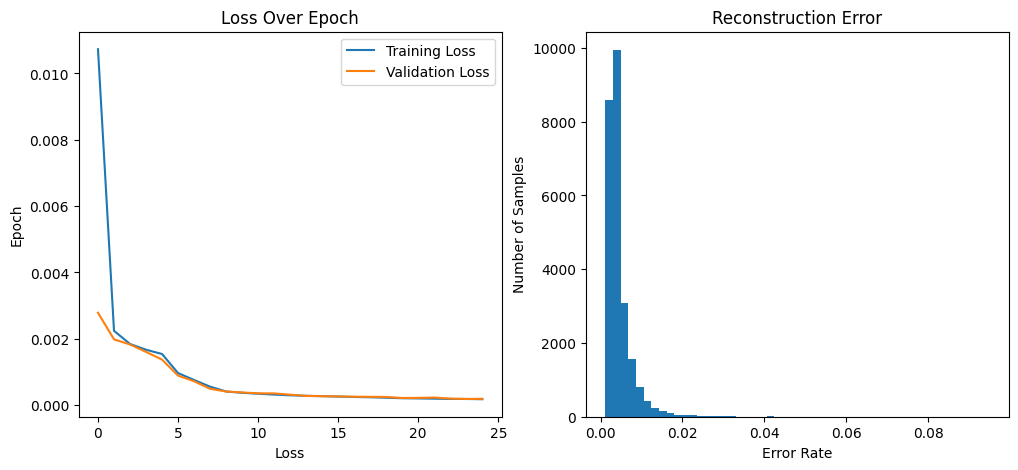

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].plot(history.history['loss'], label='Training Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Loss Over Epoch')
ax[0].set_xlabel('Loss')
ax[0].set_ylabel('Epoch')
ax[0].legend()

ax[1].hist(reconstruct_error, bins=50)
ax[1].set_title('Reconstruction Error')
ax[1].set_xlabel('Error Rate')
ax[1].set_ylabel('Number of Samples')